# Can behavioral and neural indices predict language learning ability?
Jenni Minas  

##Overview: 
I am interested in whether brain measures improve, above and beyond behavioral measures, the identification of adults who excel in language learning. An additional goal is to understand more precisely which behavioral and neural characteristics were most predictive of learning success, either independently or in combination. 

##Data 
- n = 42 native English speakers were taught a novel miniature artificial language in the lab. 
- Prior to learning, participants completed a large battery of cognitive and aptitude measures (ie: extant aptitude tests, IQ tests, working memory and open-loop (feedback based) forms of skill learning were predictive) and completed an fMRI scan while performing three separate tasks and during rest. 

- The artificial language (MAL) was learned somewhat naturalistically over the course of 4 days.* After each learning session, participants were tested for knowledge of all aspects of the language. 

- Tasks during scanning measured neural recruitment during working memory, skill learning and language processing. 

- **234 potential features (at least)

##Analysis - 
- Learning outcome is median split on measures of grammatical learning and semantic processing (meaning and content of the language)

###Run classifier model on:
- Behavioral predicts good vs bad learners
- Brain data predics good vs bad learners
- Behavioral + Brain

###Figure out which characteristics are most predictive of learning success:
- which behavioral feature
- which  neural features (ie tasks, which brain regions)

If this works, it could be the first demonstration that brain measure can help identify successful learning and contributes to our understanding about which aspects of cognitive and neural architecture contribute to learning success.

Potential problems: Data set is small small small. We need to reduce features like mad. 

*participants observed 360 narrated scenes on a computer and repeated the narrations while trying to learn the language, which was comprised of 30 nouns, 4 verbs, 2 determiners, followed subject-object-verb word order, and had regular determiner-word pairings and subject-verb agreement. 


In [2]:
#My data

import pandas as pd
import numpy as np
#import seaborn as sns
from matplotlib.colors import colorConverter
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
%pylab inline

data = pd.read_csv('../../../../LAP/LAP_MASTER_012814_jm.csv')
data.index = data.participant
keys = pd.read_csv('../../../../LAP/KEY_012814_jm.csv')

Populating the interactive namespace from numpy and matplotlib


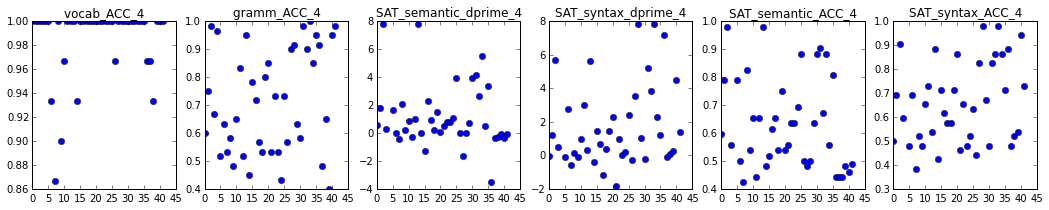

In [3]:
#Independent variable
ivkeys = ['Age'] + keys.Measures[keys.Type == 'Behavioral'].tolist()
ivkeys.remove('Videogame_Score') #this is weird

#dependent (we can look at the 4th day of languahge training or the 3 month follow up...i am going to start
#with day 4 (last day of training) outcomes)
dvkeys = [key for key in keys.Measures[keys.Type == 'Training'].tolist() if key.endswith('_4')]


v = pd.DataFrame()
for i in dvkeys:
    v = v.append(data[i])
v = v.T


#lets look at the dv (training outcomes!)
scatter, axes = plt.subplots(1,len(v.columns), figsize= (18,3))
for col, ax in zip(v.columns, axes):
    ax.plot(v[col],'o')
    ax.set_title('%s ' % col)
    #ax.set_ylabel('Accuracy')
    
dvkeys.remove('vocab_ACC_4') # not a lot of variablity, people are pretty much at ceiling

In [4]:
#what do my iv's look like, do i have variables for every measure?
print "Counting each column (number of participants with no missing data): "
print ""
print zip(data[ivkeys], data[ivkeys].count().values)
print ""
print "Number of participants left when removing any missing data: ", data[ivkeys].dropna().count().values.min()

Counting each column (number of participants with no missing data): 

[('Age', 42), ('KBIT_verbalstd', 42), ('KBIT_nonverbalstd', 42), ('KBIT_overall', 42), ('WJ3_raw', 41), ('WJ3_std', 41), ('TONI_raw', 42), ('TONI_std', 42), ('CNREPtotalraw', 42), ('Caplan_ACC', 42), ('Caplan_RT', 42), ('CVMT_dPrime', 42), ('PCT_ACC', 41), ('PCT_Opt_Acc', 41), ('RSPAN_Load_%3', 42), ('RSPAN_Load_%4', 42), ('RSPAN_Load_%5', 42), ('RSPAN_Load_%6', 42), ('RSPAN_Load_%7', 42), ('RSPAN_LetterScore', 42), ('RSPAN_sent_acc', 42), ('MLAT_Spelling_Clues_Raw', 42), ('MLAT_WordsSent_Raw', 42), ('MLAT_PairedAssoc_Raw', 42), ('MLAT_Total_Raw', 42), ('MLAT_Total_PercAir', 42), ('MLAT_Total_Perc', 42), ('statcat_WS', 38), ('statcat_3words', 38), ('statcat_2words', 38), ('rotary_delta', 42), ('mirror_deltaE', 41), ('mirror_deltaT', 41), ('CVLT_ListATotal_raw', 42), ('CVLTListATotal_Scaled', 42), ('CVLT_ListA_ShortDelay_raw', 42), ('CVLT_ListA_ShortDelay_scaled', 42), ('CVLT_LongDelay_raw', 42), ('CVLT_LongDelayScale

In [5]:
sortidx = np.argsort(data[ivkeys].count().values)
ivkeys = np.array(ivkeys)[sortidx].tolist()

print "\nComputing participants remaining as columns are removed (starting with the columns with least data)" 
print "No removed, key, number of participants remaining"

count_idx = 0
for idx in range(len(ivkeys)):
    count = data[ivkeys[(idx + 1):]].dropna().count().values.min()
    print ivkeys[idx], count
    if count == 42:
        count_idx = idx + 1
        break
print "\nKeys removed: ", ivkeys[:count_idx]
ivkeys = ivkeys[count_idx:]
ivbrainkeys = ivkeys + keys.Measures[keys.Type == 'EEG'].tolist()


Computing participants remaining as columns are removed (starting with the columns with least data)
No removed, key, number of participants remaining
statcat_2words 35
statcat_3words 35
statcat_WS 38
HILAB_Processing.Speed.TS 38
mirror_deltaE 38
WJ3_raw 38
WJ3_std 39
mirror_deltaT 40
HILAB_SwitchCost.RT 40
HILAB_MixCost.RT 41
PCT_ACC 41
PCT_Opt_Acc 42

Keys removed:  ['statcat_2words', 'statcat_3words', 'statcat_WS', 'HILAB_Processing.Speed.TS', 'mirror_deltaE', 'WJ3_raw', 'WJ3_std', 'mirror_deltaT', 'HILAB_SwitchCost.RT', 'HILAB_MixCost.RT', 'PCT_ACC', 'PCT_Opt_Acc']


In [6]:
print ivkeys, len(ivkeys)
print ""
print dvkeys, len(dvkeys)

['CVLT_Discriminability_Recognition', 'CVLT_LongDelayHIT', 'Age', 'Conscientiousness', 'CVLT_LongDelay_raw', 'CVLT_ListA_ShortDelay_scaled', 'CVLT_LongDelayScaled', 'DWECK', 'HILAB_Processing.Speed.SRT', 'Music_exp_years', 'HILAB_Paired.Associates', 'HILAB_Serial.Reaction.Time', 'HILAB_SRT.Anticipations', 'HILAB_Phonemic.Disc', 'HILAB_Letter.Span', 'HILAB_Running.Span', 'HILAB_Stroop.RT', 'HILAB_ALTM', 'HILAB_Phonemic.Cat', 'HILAB_PhonCat.Learning', 'GRIT', 'CVLT_ListA_ShortDelay_raw', 'rotary_delta', 'CVLT_ListATotal_raw', 'KBIT_verbalstd', 'KBIT_nonverbalstd', 'KBIT_overall', 'TONI_raw', 'TONI_std', 'CNREPtotalraw', 'Caplan_ACC', 'Caplan_RT', 'CVMT_dPrime', 'RSPAN_Load_%3', 'RSPAN_Load_%4', 'RSPAN_Load_%5', 'RSPAN_Load_%6', 'RSPAN_Load_%7', 'RSPAN_LetterScore', 'RSPAN_sent_acc', 'MLAT_Spelling_Clues_Raw', 'MLAT_WordsSent_Raw', 'MLAT_PairedAssoc_Raw', 'MLAT_Total_Raw', 'MLAT_Total_PercAir', 'MLAT_Total_Perc', 'HILAB_NonWord.Span', 'CVLTListATotal_Scaled', 'HILAB_Simon'] 49

['gramm_AC

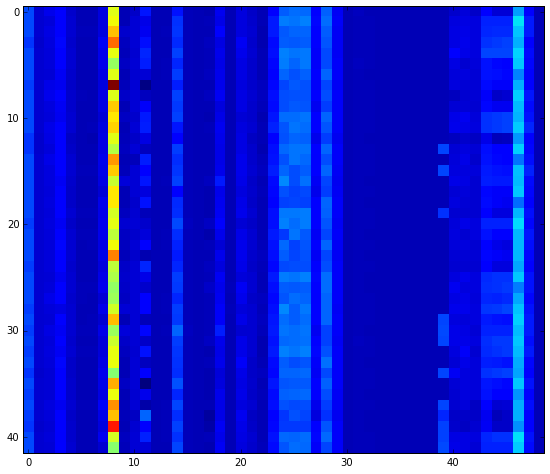

In [7]:
figure(figsize=(20, 8))
cleandata = data[ivkeys].dropna()
imshow(cleandata, interpolation='nearest', cmap='jet')
grid=True
#cleandata

NameError: name 'sns' is not defined

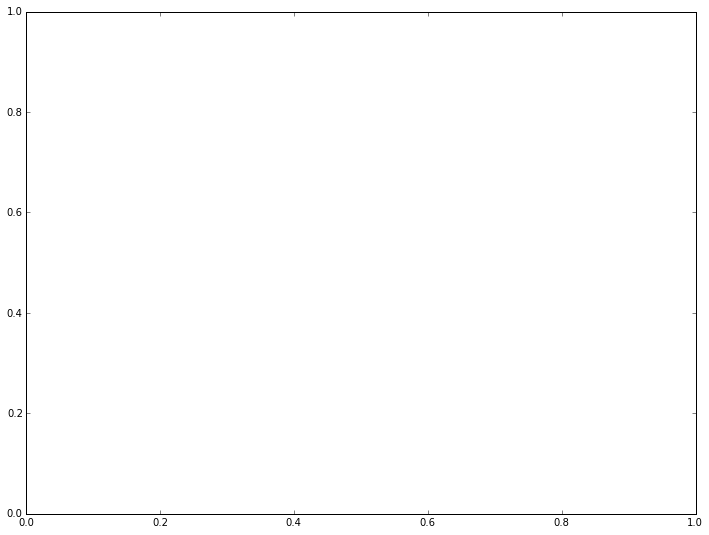

In [8]:
corrmat = cleandata.corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))
# Draw the heatmap using seaborn
sns.heatmap(corrmat,  cmap='jet') #vmax=.8, square=True,
f.tight_layout()

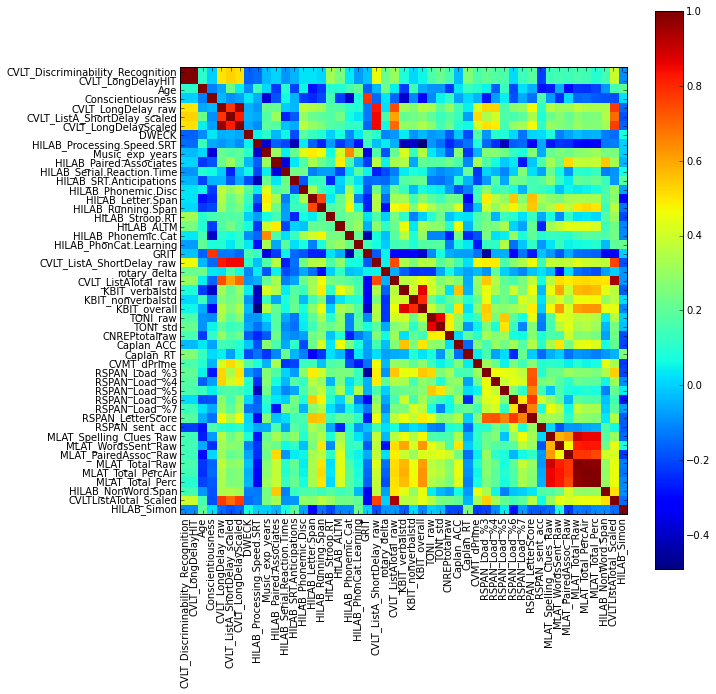

In [9]:
feature_aff = np.corrcoef(cleandata.T)
figure(figsize=(10,10))
imshow(feature_aff, interpolation='nearest', cmap='jet') #, vmax=1, vmin=-1)
yticks(range(cleandata.shape[1]), cleandata.T.index, rotation=0)
xticks(range(cleandata.shape[1]), cleandata.T.index, rotation=90)
colorbar()
grid=True

<matplotlib.colorbar.Colorbar instance at 0x7ff3f84e92d8>

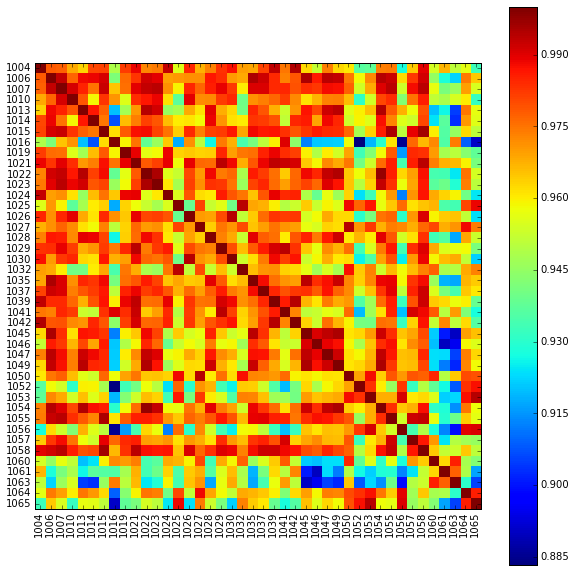

In [10]:
aff = np.corrcoef(cleandata)
figure(figsize=(10,10))
imshow(aff, interpolation='nearest', cmap='jet')#, vmax=1, vmin=-1)
yticks(range(cleandata.shape[0]), cleandata.index, rotation=0)
xticks(range(cleandata.shape[0]), cleandata.index, rotation=90)

colorbar()

# CLUSTERING - spectoral for smaller n

In [11]:

from sklearn.cluster import spectral_clustering, SpectralClustering, KMeans

<matplotlib.colorbar.Colorbar instance at 0x7ff3e1fefc20>

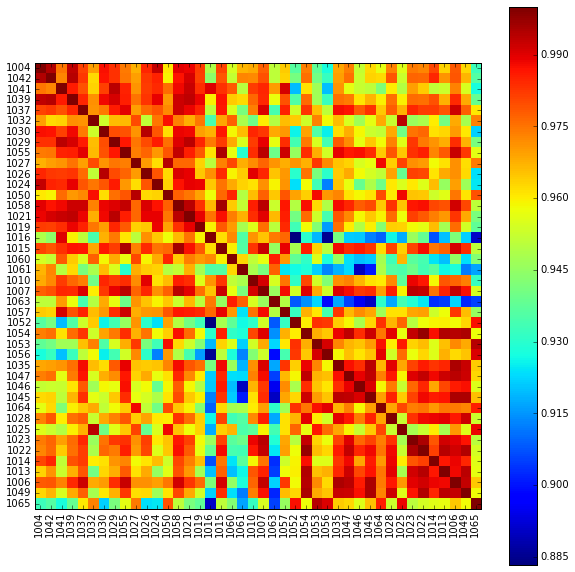

In [12]:
#labels = spectral_clustering(aff, n_clusters=4, assign_labels='discretize')

labels = SpectralClustering(n_clusters=2, assign_labels='discretize',
                            affinity='precomputed').fit(aff).labels_

sortedlabels = np.argsort(labels)
figure(figsize=(10,10))
imshow(aff[:, sortedlabels][sortedlabels, :], interpolation='nearest', cmap='jet') #, vmax=1, vmin=-1)
yticks(range(cleandata.shape[0]), cleandata.index[sortedlabels], rotation=0)
xticks(range(cleandata.shape[0]), cleandata.index[sortedlabels], rotation=90)
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7ff3e1d04248>

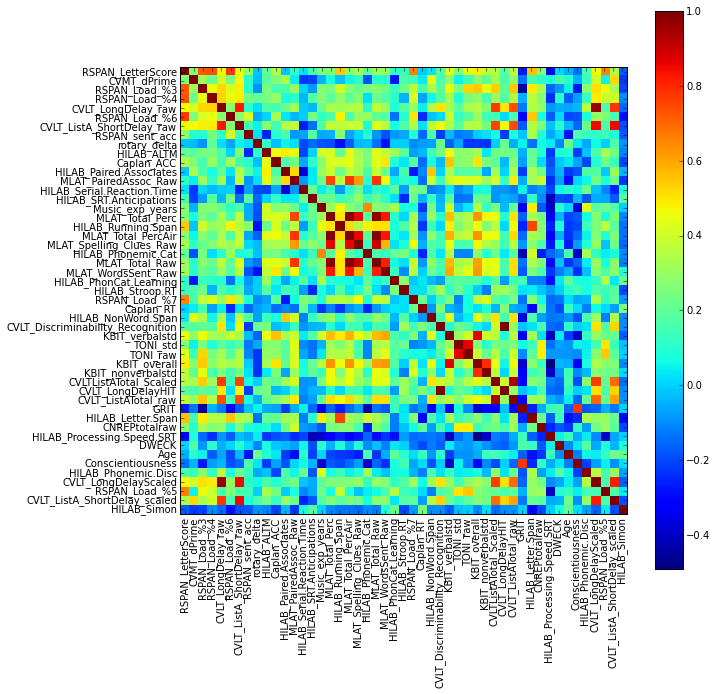

In [13]:
labels = SpectralClustering(n_clusters=6, assign_labels='discretize',
                            affinity='linear').fit(cleandata.T).labels_
sortedlabels = np.argsort(labels)
figure(figsize=(10,10))
imshow(feature_aff[:, sortedlabels][sortedlabels, :], interpolation='nearest', cmap='jet') #, vmax=1, vmin=-1)
yticks(range(cleandata.shape[1]), cleandata.T.index[sortedlabels], rotation=0)
xticks(range(cleandata.shape[1]), cleandata.T.index[sortedlabels], rotation=90)
colorbar()

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold, ShuffleSplit, StratifiedShuffleSplit, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR, SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score, r2_score, f1_score, matthews_corrcoef
from IPython.display import display

In [22]:
Xkeys = ivkeys
dataclean = data[ivkeys + dvkeys].dropna()
print dataclean.shape

X = np.array(dataclean[Xkeys])
print X.shape

Y = np.array(dataclean[dvkeys])
Y = 2 * (Y > np.median(Y, axis=0)) - 1 #median split with outcomes (good or bad learners)

print Y.shape

(41, 54)
(41, 49)
(41, 5)


## Prediction with cross-validation

http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
feature reduction and combine with gridsearch

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123)

In [32]:
#F1 score

allresults = {}
for idx in range(Y.shape[1]):
    results = [[], []]
    scores = []
    clfs = []
    for train, test in StratifiedShuffleSplit(Y[:, idx], n_iter=200, test_size=0.3):
    #for X_train, X_test, y_train, y_test in train_test_split(X, Y, test_size=0.3): #, random_state=123): 
   
        #RBF and linear kernel SVM classifier, and let's try different parameters of C.
            #rbf - uses 'radial basis functions' centered at each support vector to assemble a decision frontier. 
            #linear - will give linear decision frontiers. It is the most computationally efficient approach and the one that requires the least amount of data.
        
        parameters = {'model__kernel': ('linear', 'rbf',), 'model__C':[0.1, 1, 10, 100]} #no gamma???
        
        clf = Pipeline([('scaler', StandardScaler()), ('model', SVC())])
        clf = GridSearchCV(clf, parameters, n_jobs=8)
        
        ytest = clf.fit(X[train], Y[train, idx]).predict(X[test])
        
        results[0].extend(Y[test, idx])
        results[1].extend(ytest)
        scores.append(f1_score(Y[test, idx], ytest, [-1, 1]))        
        clfs.append((clf.best_params_))
        
    score = f1_score(results[0], results[1],  [-1,1])
    allresults[dvkeys[idx]] = {'results': results, 'f1': score,
                               'scores': scores, 'median_f1': np.median(scores),
                               'clfs': clfs}

In [34]:
f1_results = pd.DataFrame([{'name': k, 
                           'median_f1': allresults[k]['median_f1'], 
                           'f1': allresults[k]['f1']} 
                          for k in allresults]).sort('median_f1', ascending=False)
f1_results

,f1,median_f1,name
3,0.750905,0.769231,SAT_syntax_dprime_4
0,0.688648,0.714286,SAT_syntax_ACC_4
1,0.679108,0.666667,gramm_ACC_4
4,0.552104,0.571429,SAT_semantic_dprime_4
2,0.544304,0.545455,SAT_semantic_ACC_4


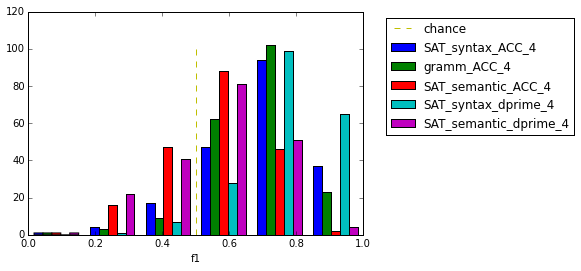

In [35]:
ans = hist([allresults[key]['scores'] for key in allresults], 6)
maxval = np.max([val for val in ans[0]])
plot([0.5, 0.5], [0, maxval], '--')
legend(['chance'] + allresults.keys(), bbox_to_anchor=(1.05, 1), loc=2)
xlabel('f1')

In [46]:
## does adding an ensenble method help?
# remember to add a few other ones (randomforrest, etc)

allresults_extree = {}
for idx in range(Y.shape[1]):
    results_extree = [[], []]
    scores_extree = []
    clfs_extree = []
    for train, test in StratifiedShuffleSplit(Y[:, idx], n_iter=200, test_size=0.2):
        clf_extree = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=1)
        ytest_extree = clf_extree.fit(X[train], Y[train, idx]).predict(X[test])
        results_extree[0].extend(Y[test, idx])
        results_extree[1].extend(ytest_extree)
        scores_extree.append(f1_score(Y[test, idx], ytest_extree, [-1, 1]))
        clfs_extree.append(clf_extree.feature_importances_)
    score_extree = f1_score(results_extree[0], results_extree[1], [-1,1])
    allresults_extree[dvkeys[idx]] = {'results': results_extree, 'f1': score_extree,
                               'scores': scores_extree, 'median_f1': np.median(scores_extree),
                               'clfs': clfs_extree}

In [47]:
f1_results_extree = pd.DataFrame([{'name': k, 
                           'median_f1_extratree': allresults_extree[k]['median_f1'], 
                           'f1_extra_tree': allresults_extree[k]['f1']} 
                          for k in allresults_extree]).sort('median_f1_extratree', ascending=False)
f1_results_extree

,f1_extra_tree,median_f1_extratree,name
3,0.743175,0.750000,SAT_syntax_dprime_4
0,0.689292,0.666667,SAT_syntax_ACC_4
1,0.680726,0.666667,gramm_ACC_4
4,0.411933,0.444444,SAT_semantic_dprime_4
2,0.416715,0.400000,SAT_semantic_ACC_4


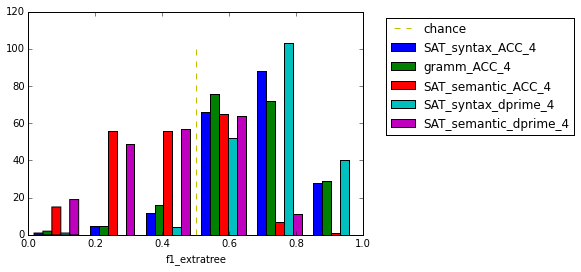

In [48]:
ans = hist([allresults_extree[key]['scores'] for key in allresults_extree], 6)
maxval = np.max([val for val in ans[0]])
plot([0.5, 0.5], [0, maxval], '--')
legend(['chance'] + allresults_extree.keys(), bbox_to_anchor=(1.05, 1), loc=2)
xlabel('f1_extratree')

# show the important features

In [63]:
for key in allresults:
    sortidx = np.argsort(np.mean(allresults[key]['clfs'], axis=0))
    figure(figsize=(10, 10))
    imshow(np.array(allresults[key]['clfs'])[::10, sortidx].T, interpolation='nearest')
    title(key)
    ans = yticks(range(len(Xkeys)), np.array(Xkeys)[sortidx])
    colorbar()

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'